# EDA of Training set

In [2]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datasets import load_dataset
from collections import Counter
from wordcloud import WordCloud
import re

sns.set(style="whitegrid")

In [3]:
# Safe loader for PathVQA Yes/No EDA (skips images entirely)

from datasets import load_dataset

def load_yesno_split(split):
    # Load only text columns; ignore 'image' field entirely
    ds = load_dataset(
        "flaviagiammarino/path-vqa",
        split=split,
        streaming=False  # use local caching, not streaming
    )

    # Convert to pandas so we can drop the heavy image column easily
    df = ds.to_pandas()[["question", "answer"]]

    # Filter for yes/no answers
    df = df[df["answer"].str.strip().str.lower().isin(["yes", "no"])].reset_index(drop=True)
    return df

train_data = load_yesno_split("train")
val_data = load_yesno_split("validation")
test_data = load_yesno_split("test")

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")
train_data.head()

Train samples: 9751
Validation samples: 3125
Test samples: 3362


,question,answer
0,is embolus derived from a lower-extremity deep...,yes
1,is normal palmar creases present?,no
2,does this image show excellent photo typical a...,yes
3,does typical tuberculous exudate show excellen...,no
4,is gastrointestinal present?,yes


In [5]:
train_data.isna().sum()

question    0
answer      0
dtype: int64

In [21]:
# Quick Text Insights

def quick_text_summary(df, name):
    questions = df["question"].dropna().tolist()
    avg_len = np.mean([len(q.split()) for q in questions])
    examples = np.random.choice(questions, 3, replace=False)
    
    print(f"\n {name.upper()} SET: Avg Length = {avg_len:.2f}")
    print("  Example Questions:")
    for e in examples:
        print("   •", e)

quick_text_summary(train_df, "train")
quick_text_summary(val_df, "validation")
quick_text_summary(test_df, "test")



 TRAIN SET: Avg Length = 7.44
  Example Questions:
   • is granulomata slide a close-up view of the typical cold abscess exudate on the liver surface?
   • does this image show normal cardiovascular?
   • does this image show gaucher disease?

 VALIDATION SET: Avg Length = 7.35
  Example Questions:
   • does this image show alcoholic cirrhosis?
   • does atrophy secondary to pituitectomy show esohagus, candida?
   • is myelomonocytic leukemia present?

 TEST SET: Avg Length = 7.46
  Example Questions:
   • does this image show simian crease?
   • does this image show tracheotomy site, granulation tissue?
   • is atherosclerosis present?


In [11]:
# Summary of yes/no counts per split

def summarize_basic_info(df, split_name):
    total = len(df)
    yes_count = (df["answer"].str.strip().str.lower() == "yes").sum()
    no_count = total - yes_count
    
    print(f"\n{split_name.upper()} SPLIT")
    print(f"Total: {total}")
    print(f"Yes: {yes_count} ({yes_count/total:.2%}) | No: {no_count} ({no_count/total:.2%})")
    
    return {
        "split": split_name,
        "total": total,
        "yes": yes_count,
        "no": no_count
    }

summaries = [
    summarize_basic_info(train_df, "train"),
    summarize_basic_info(val_df, "validation"),
    summarize_basic_info(test_df, "test")
]

df_summary = pd.DataFrame(summaries)
df_summary


TRAIN SPLIT
Total: 9751
Yes: 5378 (55.15%) | No: 4373 (44.85%)

VALIDATION SPLIT
Total: 3125
Yes: 1712 (54.78%) | No: 1413 (45.22%)

TEST SPLIT
Total: 3362
Yes: 1816 (54.02%) | No: 1546 (45.98%)


,split,total,yes,no
0,train,9751,5378,4373
1,validation,3125,1712,1413
2,test,3362,1816,1546


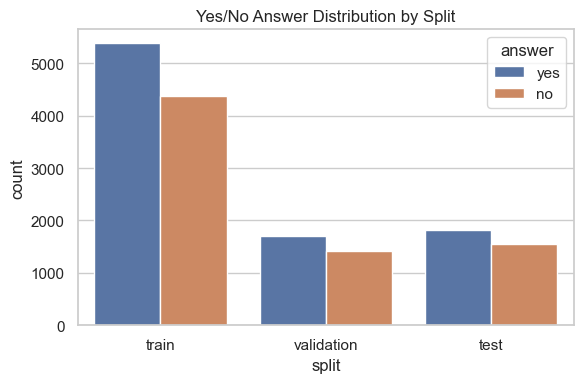

In [12]:
# Visualize Yes/No distribution by split

df_melted = df_summary.melt(id_vars="split", value_vars=["yes", "no"],
                            var_name="answer", value_name="count")

plt.figure(figsize=(6, 4))
sns.barplot(x="split", y="count", hue="answer", data=df_melted)
plt.title("Yes/No Answer Distribution by Split")
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


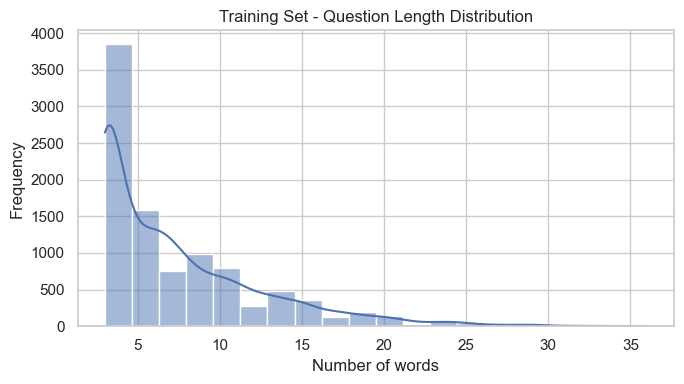

Average length: 7.44
Median length: 6


In [15]:
# Analyze question lengths in training set

# Extract questions directly from the DataFrame
train_questions = train_df["question"].dropna().tolist()

# Compute word counts per question
lengths = train_df["question"].dropna().apply(lambda q: len(q.split())).tolist()

# Plot histogram
plt.figure(figsize=(7, 4))
sns.histplot(lengths, bins=20, kde=True)
plt.title("Training Set - Question Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Summary stats
print(f"Average length: {np.mean(lengths):.2f}")
print(f"Median length: {np.median(lengths):.0f}")


In [16]:
# Most common question prefixes (first words)

prefixes = [q.strip().lower().split()[0] for q in train_questions if q.strip()]
prefix_counts = Counter(prefixes)

pd.DataFrame(prefix_counts.most_common(15),
             columns=["Prefix", "Count"])


,Prefix,Count
0,is,5161
1,does,3758
2,are,509
3,do,233
4,did,29
5,has,18
6,was,17
7,have,12
8,what,4
9,were,4


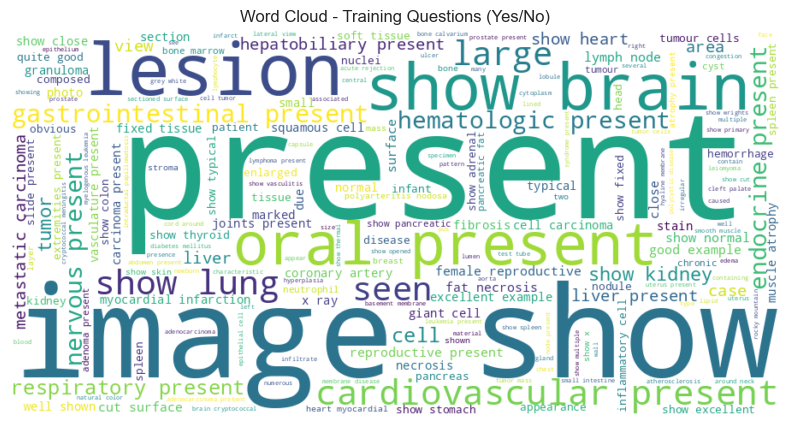

In [17]:
# Word cloud of training questions

all_text = " ".join(train_questions)
wordcloud = WordCloud(width=900, height=450, background_color="white").generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Training Questions (Yes/No)")
plt.show()